# CIFAR - 10


https://www.kaggle.com/c/cifar10


CIFAR-10 dataset is a popular dataset to measure performance on image classification tasks.It contains 60,000 32x32 color images in 10 different classes. It’s divided into 50,000 training examples and 10,000 test examples.

## Goal

To train best posible model with minimal code and in as little time as possible.
To do so I'm going to be using a high-level wrapper over PyTorch -  fastai framework.It offers easy APIs and strong deafults to build very good image classification baseline.


In [41]:
from fastai.vision.all import *

In [42]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.1
torch2trt==0.1.0
torchvision==0.8.2
fastai==2.3.0
fastai2==0.0.30
fastbook==0.0.16
fastcore==1.3.19
fastprogress==1.0.0
fastrelease==0.1.11


The CIFAR dataset is already provided as a sample dataset in the fastai library. (Similar to `torchvision.datasets`)

In [2]:
path = untar_data(URLs.CIFAR)

## Building the data sets

General approches in training:

**Image Augmentation:** cropping, padding, rotating are commonly used while training neural networks. This helps to avoid overfitting and generalize better without having to actually collect any new data. The simplest way to do this is to use the aug_transformsin fastai which lets you choose from a standard set of transforms.

**Splitting dataset into train-validation-test sets:**  Here Im using 20 percent of the data for validatation. fastai provides an easy way to load  data and split it if it’s already stored in some standard format

**Reproducibility** By setting the `seed=42` we get reproducibility

**Transfer Learning:**  Transfer learning is the easiest way to achive good results quickly. Start with ResNet50 trained on ImageNet. We dfine a new head initialized randomly. This head is adapted to the number of classes needed for the new classification . By calling finetune on the cnn_learner by default, we keep the body frozen and only train the head in the first run and then the entire model.

**Input size:**  The ResNet was originally trained on 224x224 images and our dataset has 32x32 images. Input images that are too different from the original size, are not optimal for the model. Scaling up the images to 128x128 improves accuracy greatly

In [3]:
# tfms = aug_transforms(do_flip=False)
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(128))
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

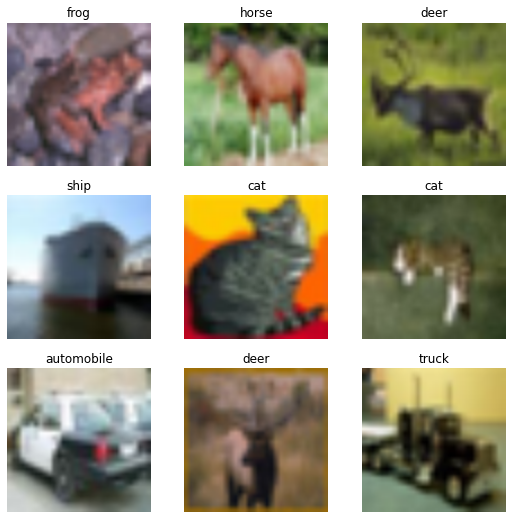

In [4]:
data.show_batch()

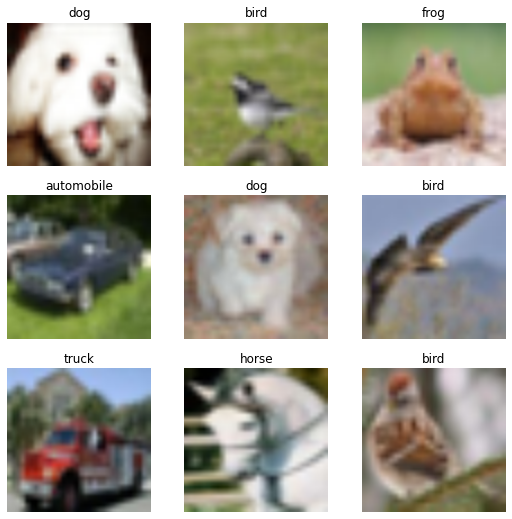

In [5]:
data.valid.show_batch()

## Training time:

In [6]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.431244,0.310377,0.896583,02:29


epoch,train_loss,valid_loss,accuracy,time
0,0.185257,0.139085,0.953833,03:14


In [64]:
learn.save('stage-1-1e-0.95')

Path('/home/jelena/.fastai/data/cifar10/models/stage-1-1e-0.95.pth')

The model performance is excellent after just few epochs with the deafult parameters. To take it further the next step would be to train for a few more epochs and fine tune furrther while picking a good variable learning rate.

In [65]:
learn.load('stage-1-1e-0.95')

A look at the training curve gives us a way to chose a reasonable training rate. 

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775847473997e-07)

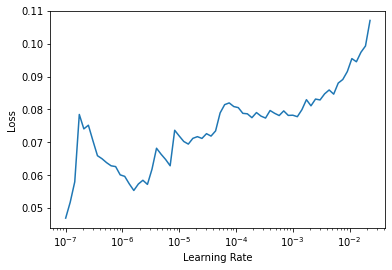

In [61]:
learn.lr_find()

With a slice, where the first value is used as the learning rate of first layers, the second for learning rate of the final layer and the layers in between would have values in between.

We unfreeze the body and train the whole network.

In [66]:
learn.unfreeze()

In [67]:
learn.fit_one_cycle(1, lr_max=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.076256,0.135884,0.957250,03:15


In [68]:
learn.validate()

(#2) [0.13588355481624603,0.9572499990463257]

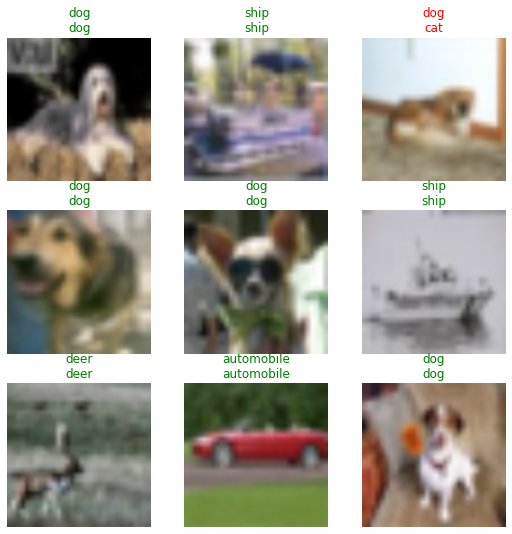

In [69]:
learn.show_results()

## Make the test data loader:

The test set is 10,000 images in the official data and the fastai dataset. However, to discourage certain forms of cheating (such as hand labeling) Kaggle hass added 290,000 junk images in the test set. These images are ignored in the scoring. Therefore we create a test data loader for the 300k images downloaded from kaggle.

In [70]:
tst_files = get_image_files('/home/jelena/cifar10/test')

In [71]:
tst_dl = data.test_dl(tst_files)

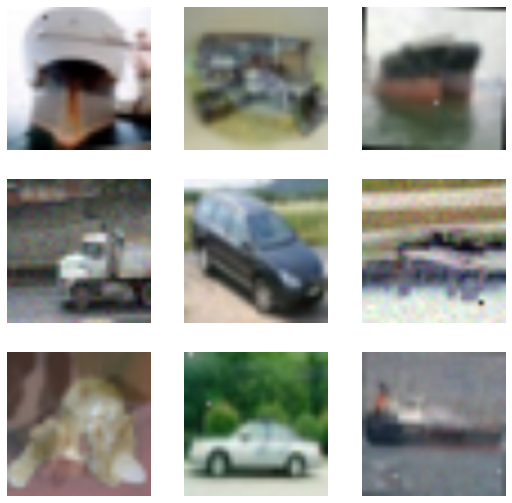

In [72]:
tst_dl.show_batch()

## Run the model on the test data:

In [73]:
preds, _ = learn.get_preds(dl = tst_dl)

In [74]:
labels = np.argmax(preds, 1)

### *Sanity cheks:*

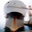

In [75]:
img = PILImage.create('/home/jelena/cifar10/test/' + filenames[0]); img

In [76]:
labels[0]

tensor(8)

## Make submission file:

The subbmison file should contain the label and id. *The id is actually the filename!!!*

In [77]:
filenames = []
for i in range(len(preds)):
    filenames.append(str(tst_dl.items[i]).split('/')[-1])

In [78]:
df = (pd.DataFrame(data={"label": labels, "Filename": [f.replace('.png', '') for f in filenames]})
      .sort_values(by='Filename'))

In [80]:
labels_dict =  {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
df.replace({"label":labels_dict}, inplace=True)
df.columns = ['id', 'label']
df.to_csv("submit02.csv", index=False)

In [82]:
# ! ls
# !kaggle competitions submit -c cifar-10 -f submit01.csv -m "Message"

This submision gets a `0.98520` score on the kaggle leaderboard  🔥